RNN 中的矩阵连乘可能会带来梯度消失或爆炸的问题，这种**梯度异常**可能导致：
- 早期观测值对预测所有未来观测值具有非常重要的意义。有时第一个词元的影响至关重要，希望能有某些机制能够在一个记忆元里**存储**重要的早期信息。
- 一些 token 没有相应的观察值，比如对网页内容进行情感分析时，HTML代码并没有什么用处。希望有一些机制来**跳过**隐状态表示中的此类词元。
- 书的各章之间内容是独立的，扫描到下一章时希望能清空上一章保存的状态。最好有一种方法来**重置**我们的内部状态表示。

# 1. 门控隐状态

GRU 和 普通 RNN 的区别在于：有专门的机制来确定应该何时更新隐状态，以及应该何时重置隐状态。这些机制是可学习的，
同样，模型也可以学会**跳过**不相关的临时观测。 最后，模型还将学会在需要的时候**重置**隐状态。

### (1) 重置门（reset gate）和更新门（update gate）
重置门允许我们**控制“可能还想记住”的过去状态的数量**,是一种遗忘机制。
更新门将允许我们**控制新状态中有多少个是旧状态的副本**，是一种关注机制。

这两种门都需要维护参数：
1. 当前时刻的输入 $X_t$ ，权重参数($\mathbb{R}^{d \times h}$)
2. 前一时刻的隐状态$H_{t-1}$ ，权重参数($\mathbb{R}^{h \times h}$)
3. 偏置参数($\mathbb{R}^{1 \times h}$)

重置门和更新门的公式一模一样，它俩的区别在于被使用的方式。

### (2) 候选隐状态
重置门 $R_t \in \mathbb{R}^{n \times h}$ 影响了候选隐状态 $\tilde{H}_{t} \in \mathbb{R}^{n \times h}$ :
$$ \tilde{H}_{t} = tanh(X_tW_{xh} + (\textcolor{red}{R_t \bigodot} H_{t-1})W_{hh}+b_h) $$

注意，激活函数 $tanh$ 将 $\tilde{H}$ 矩阵的值保持在区间(-1,1)中。

### (3) 隐状态
更新门 $Z_t \in \mathbb{R}^{n \times h}$ 影响了隐状态 $H_t \in \mathbb{R}^{n \times h}$,
$Z_t$ 决定了 $H_t$ 在多大程度上来自 $H_{t-1}$ 和 $\tilde{H}$:
$$H_t = Z_t \bigodot H_{t-1} + (1 - Z_t) \bigodot \tilde{H}_t$$

当 $Z_t$ 接近 1 时，模型倾向于保留旧状态，此时，来自$X_t$的信息基本上被忽略， 从而有效地跳过了依赖链条中的时间步$t$。
当 $Z_t$ 接近 0 时，模型就会倾向于候选隐状态。
这些设计有助于处理循环网络的梯度消失问题，并更好地捕获时间步距离很长的序列的依赖关系。
例如，如果整个子序列的所有时间步的更新门都接近于1，则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

### 总结，GRU具有两个显著特征：
- 重置门有助于捕获序列中的短期依赖关系；
- 更新门有助于捕获序列中的长期依赖关系。

# 2. 无框架实现

### (1) 初始化模型参数

In [19]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [20]:
# 输出数据的维度，隐藏层维度，GPU
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 生成指定大小的随机矩阵
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  # 取值有 99.73% 的可能落在[-3,3] 区间

    # 生成(输入层 - 隐藏层)(t-1隐藏层 - t隐藏层)(隐藏层 - 输出层)矩阵
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门维护的参数
    W_xr, W_hr, b_r = three()  # 重置门维护的参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for p in params:
        p.requires_grad_(True)
    return params

### (2) 定义模型
`init_gru_state`函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [21]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [22]:
#  *是对位相乘，@是真正的矩阵连乘
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

### 3. 训练与预测

perplexity 1.1, 10845.8 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


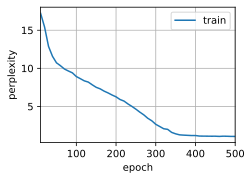

In [23]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 3. PyTorch 实现

perplexity 1.0, 86151.2 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


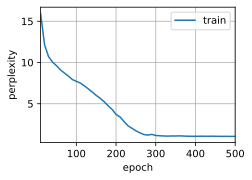

In [25]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs,num_hiddens)  # 可知，nn.GRU 被 PyTorch 设计为一个层，这意味着可以嵌入到自己的模型当中。
model = d2l.RNNModel(gru_layer,vocab_size).to(device)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# Q&A
1. gru中激活函数为什么用tanh呢，用relu或其他的激活函数可以么
> 都行，随便。
2. Z 等于 1 的时候相当于让H(t) = H(t-1)。那如果 Z 等于 0 的时候，是什么意思呢？
> Z = 0 时意味着让$H_t$忽视当前的$X_t$,仅继承 $H_{t-1}$ 的状态。
3. GRU 相比 RNN 多了这么多参数，需不需要提高grad clipping的阈值？
> 不需要，因为 GRU 的数值稳定性实际高于 RNN
4. GRU中的初始化隐藏层大小可以随便写吗，和MLP对比？
> 可以，因为 RNN 这一套和 MLP 差别不大。但一般多用 128/256/1024 等
5.normal函数中，torch.randn(size=shape,device:=device)*0.01这个地方为何乘以0.01
> 使用 0.01 这个方差出于习惯。在层数不多的网络上表现不错。